In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx

In [2]:
# Load data
df_graph = pd.read_csv('./data/graph.csv')
df_people = pd.read_csv('./data/people.csv')
df_graph = df_graph[df_graph.p1 != df_graph.p2].reset_index(drop = True)

In [25]:
# Rank by citations (total cited number by others)
corr = np.zeros((640, 640))
for j in range(len(df_graph)):
    corr[df_graph.p1[j], df_graph.p2[j]] = df_graph['count'][j]
    
citations = np.sum(corr, axis=0)
citations = sorted([(j, citations[j]) for j in range(len(citations))], key = lambda x: x[1], reverse = True)
# citations = [(df_people.iloc[citations[j][0]].name_en + '(' + df_people.iloc[citations[j][0]].name_zh + ')', 
#               citations[j][1]) for j in range(len(citations))]
# citations = [(df_people.iloc[citations[j][0]].name_en, 
#               citations[j][1]) for j in range(len(citations))]
citations = pd.DataFrame(columns=['name', 'citation'], data=citations)
citations_picked = citations[citations.citation > 50]

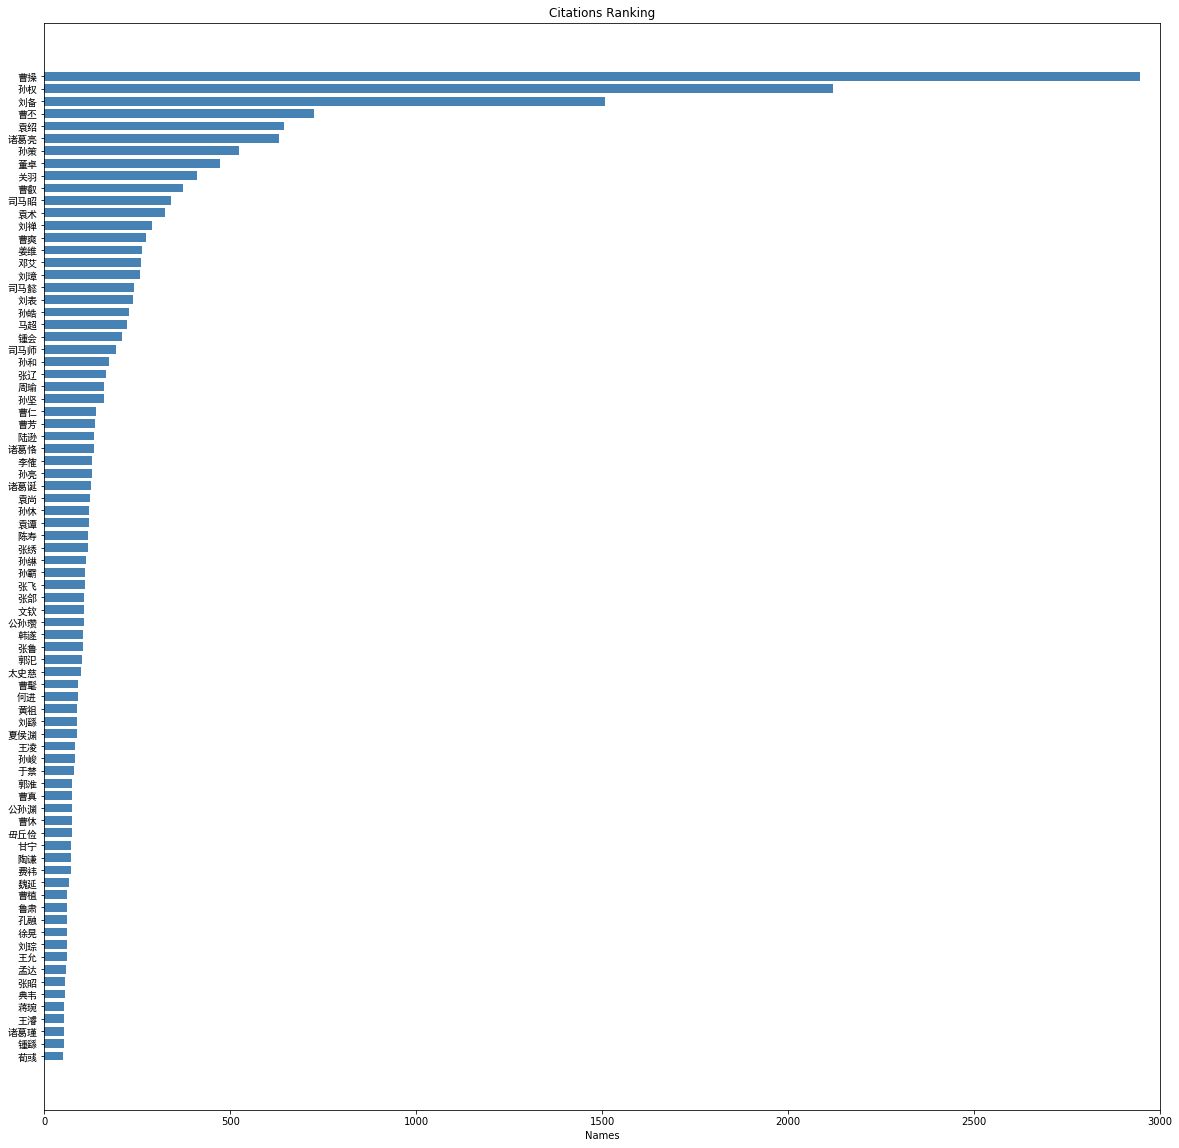

In [36]:
plt.figure(figsize = (20, 20))
plt.barh(range(len(citations_picked)), list(citations_picked.citation[::-1]), height=0.7, color='steelblue')      # 从下往上画
plt.yticks(range(len(citations_picked)), list(df_people.iloc[citations_picked.name[::-1]].name_zh), fontproperties = 'simhei')
plt.xlim(0,3000)
plt.xlabel("Names")
plt.title("Citations Ranking")
plt.show()

In [27]:
# Visualize Graph

# Pick important people
df_graph_picked = df_graph[df_graph.p1.isin(citations_picked.name)]
df_graph_picked = df_graph_picked[df_graph_picked.p2.isin(citations_picked.name)].reset_index(drop=True)

# Create undirected graph
for row in df_graph_picked.iterrows():
    edge = row[1]
    if edge.p2 < edge.p1:
        df_graph_picked.iloc[row[0]].p2, df_graph_picked.iloc[row[0]].p1 = (
            df_graph_picked.iloc[row[0]].p1, df_graph_picked.iloc[row[0]].p2)       
df_ugraph_picked = df_graph_picked.groupby(['p1', 'p2']).sum().reset_index()

In [53]:
G = nx.Graph()

for row in df_ugraph_picked.iterrows():
    edge = row[1]
    G.add_edge(edge.p1, edge.p2, weight = edge['count'])

pos = nx.spring_layout(G, dim = 2)
edgewidth = []
for (u,v,d) in G.edges(data=True):
     edgewidth.append(G.get_edge_data(u,v)['weight']/20)

/home/hengji/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


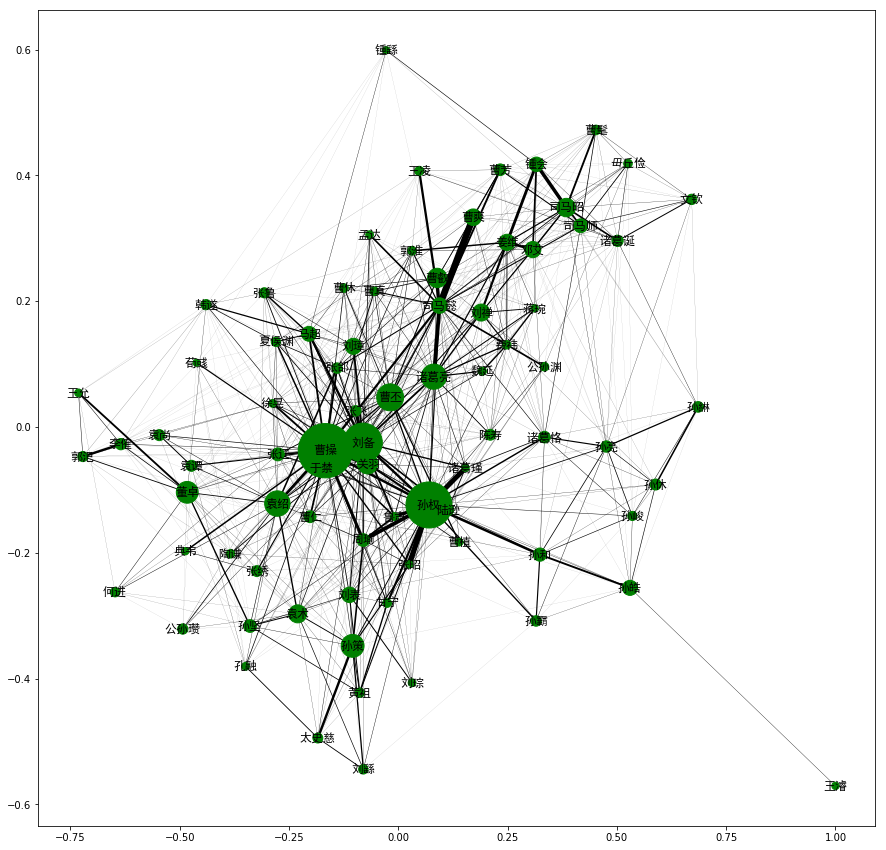

In [54]:
reordered_node_sizes = [citations_picked[citations_picked.name == j].citation.values[0] for j in list(G.nodes)]

def draw_graph(g, language):
    labels = {}
    if language == 'Chinese':
        for j in list(G.nodes):
            labels[j] = df_people.iloc[j].name_zh
        fontsize = 12
    else:
        for j in list(G.nodes):
            labels[j] = df_people.iloc[j].name_en
        fontsize = 8
    plt.figure(figsize=(15,15))
    nx.draw_networkx_edges(G, pos, width=edgewidth) 
    nx.draw_networkx_nodes(G, pos, node_size= reordered_node_sizes, node_color='g')
    nx.draw_networkx_labels(G, pos, labels, font_size=fontsize, font_family = 'simhei')
    plt.show()
    
draw_graph(G, 'Chinese')